<a href="https://colab.research.google.com/github/aleksandrast12/PUM_projekt_PZS/blob/main/Projekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
import sklearn

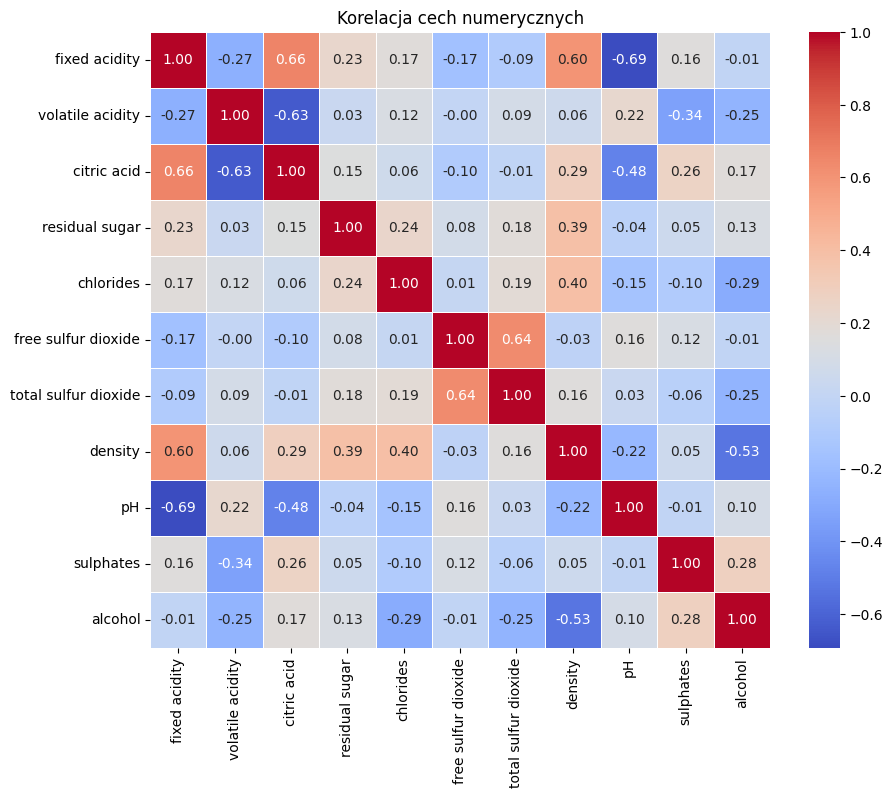

In [2]:

# y to quality

df = pd.read_csv("test.csv")

#df.drop_duplicates() - nie obowiazuje gdyz nawet przy jednym powtarzajacym sie elemencie inne cechy rozniace sie moga miec wplyw na ocene jakosci

#nie musimy usuwac kolumn
columns = ['fixed acidity',"volatile acidity","citric acid","residual sugar","chlorides","free sulfur dioxide","total sulfur dioxide","density","pH","sulphates","alcohol","quality"]
columnsnotQuality = ['fixed acidity',"volatile acidity","citric acid","residual sugar","chlorides","free sulfur dioxide","total sulfur dioxide","density","pH","sulphates","alcohol"]
FeaturesToConvert = ['citric acid','residual sugar','chlorides']
FeaturesToConvert = ['citric acid','residual sugar','chlorides']
for feature in FeaturesToConvert:
   df[feature] = df[feature].str.strip('-_')
for feature in FeaturesToConvert:
  df[feature] = df[feature].astype('float64')
for column in columns:
   df[column] = df[column].replace({'':np.nan})
#df.isna().sum()
df['density'] = df['density'].fillna(method='pad')

for column in  df[columnsnotQuality]:
  df[column]=np.abs(df[column])
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3- Q1
  df = df.drop(df.loc[df[column] > (Q3 + 1.5 * IQR)].index)
  df = df.drop(df.loc[df[column] < (Q1- 1.5 * IQR)].index)
dfnoQuality = df.drop(columns=['quality'])
scaler = preprocessing.StandardScaler().fit(dfnoQuality)
numerical_columns = dfnoQuality.select_dtypes(include=[float, int]).columns
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

features = df.drop(columns=['quality'])
plt.figure(figsize=(10, 8))
sns.heatmap(features.corr(), annot = True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title('Korelacja cech numerycznych')
plt.show()

#df.info()
#df.head()

Pozostałe cechy: Index(['fixed acidity', 'volatile acidity', 'citric acid', 'chlorides',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'quality'],
      dtype='object')


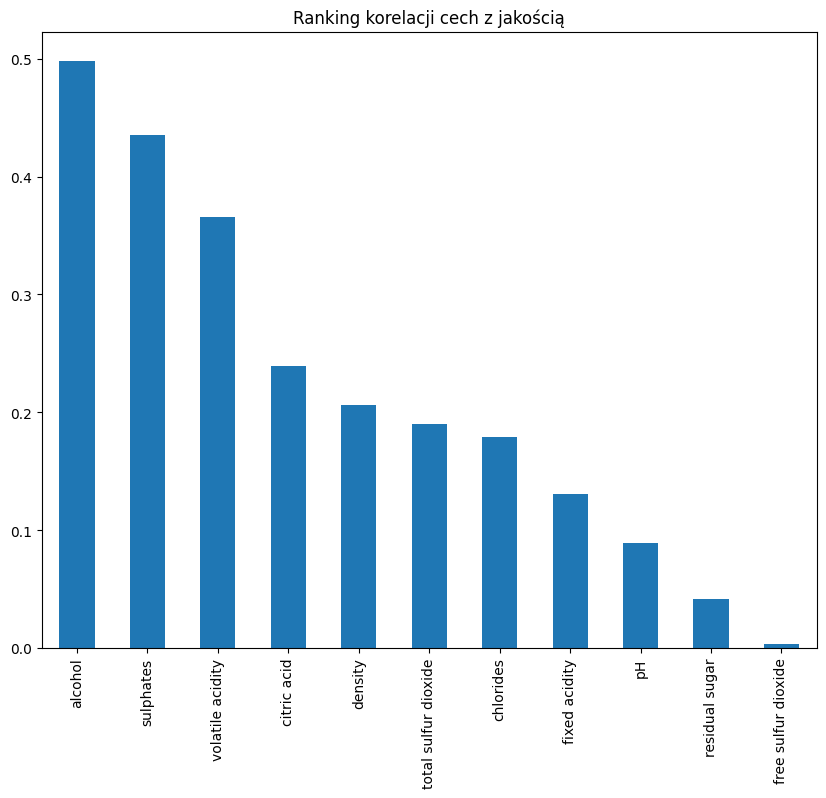

In [3]:
corr_quality = df.corr()['quality'].drop('quality').abs()
corr_quality_sort = corr_quality.sort_values(ascending=False)
corr_quality_sort.plot.bar(figsize=(10, 8))
plt.title('Ranking korelacji cech z jakością')
features_drop = corr_quality_sort.nsmallest(2).index
df_reduced = df.drop(columns=features_drop)

# wyświetlenie pozostałych cech
print("Pozostałe cechy:", df_reduced.columns)
plt.show()



wariancja [0.31309624 0.23841884 0.11592035 0.09467399 0.08080354 0.07049266
 0.05492427]


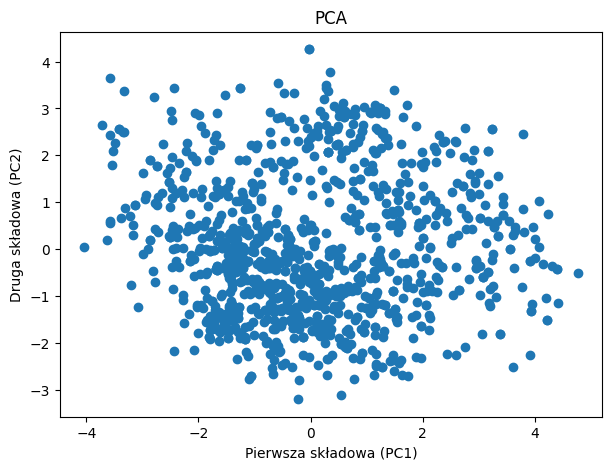

In [4]:

features = df_reduced.drop(columns=['quality'])
pca = PCA(n_components=0.95)  # zachowanie 95% wariancji
X_pca = pca.fit_transform(features)

plt.figure(figsize=(7, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.xlabel('Pierwsza składowa (PC1)')
plt.ylabel('Druga składowa (PC2)')
plt.title('PCA')
print("wariancja", pca.explained_variance_ratio_)
plt.show()

In [5]:
X_df = df_reduced[['fixed acidity','volatile acidity','citric acid', 'chlorides', 'total sulfur dioxide', 'density','pH', 'sulphates', 'alcohol']]
Y_df = df_reduced['quality']
X_train, X_test, Y_train, Y_test = train_test_split(X_df, Y_df, random_state=50)

# X_train = train_df[['fixed acidity','volatile acidity','citric acid', 'chlorides', 'total sulfur dioxide', 'density','pH', 'sulphates', 'alcohol']]
# Y_train = train_df['quality']
# X_test = test_df[['fixed acidity','volatile acidity','citric acid', 'chlorides', 'total sulfur dioxide', 'density','pH', 'sulphates', 'alcohol']]
# Y_test = test_df['quality']

# **Model Podstawowy-  Regresja Liniowa**

In [6]:
df_reduced.head()

,fixed acidity,volatile acidity,citric acid,chlorides,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.517383,1.080055,-1.364671,-0.167169,-0.282198,0.790696,1.419610,-0.610668,-1.000189,5
1,-0.240257,2.173545,-1.364671,1.434599,1.058458,0.148392,-0.962884,0.460596,-0.580549,5
2,-0.240257,1.444552,-1.142773,0.997753,0.530321,0.276853,-0.501756,0.192780,-0.580549,5
3,2.115311,-1.471421,1.741897,-0.239977,0.774077,0.919157,-1.270302,-0.432124,-0.580549,6
4,-0.517383,1.080055,-1.364671,-0.167169,-0.282198,0.790696,1.419610,-0.610668,-1.000189,5


In [8]:
linReg = LinearRegression().fit(X_train, Y_train)
linReg.score(X_train,Y_train)
linReg.coef_
linReg.intercept_
y_predic = np.round(linReg.predict(X_test))# należy zaokrąglic do całości by predykcje były w tej samej postaci co dane wejściowe
print(y_predic)

[5. 5. 6. 6. 6. 6. 7. 6. 6. 6. 5. 6. 5. 6. 6. 5. 6. 6. 5. 6. 5. 6. 5. 6.
 6. 6. 5. 6. 6. 6. 6. 6. 6. 5. 5. 5. 6. 5. 6. 5. 5. 5. 5. 5. 5. 5. 6. 5.
 6. 6. 5. 6. 5. 6. 5. 6. 5. 5. 6. 5. 5. 6. 6. 6. 6. 6. 6. 5. 5. 6. 6. 6.
 5. 5. 5. 6. 5. 5. 6. 5. 6. 5. 5. 5. 6. 6. 5. 6. 6. 6. 5. 5. 6. 6. 5. 6.
 5. 6. 6. 6. 6. 6. 6. 6. 5. 6. 5. 5. 5. 6. 5. 5. 5. 6. 5. 5. 5. 6. 5. 5.
 5. 6. 5. 6. 5. 6. 5. 6. 5. 5. 6. 6. 6. 6. 6. 6. 6. 6. 6. 5. 6. 6. 5. 6.
 6. 7. 5. 6. 6. 5. 5. 5. 6. 7. 6. 6. 6. 5. 6. 6. 6. 5. 6. 5. 5. 5. 6. 6.
 6. 6. 5. 6. 5. 6. 5. 5. 5. 6. 6. 7. 6. 5. 6. 7. 5. 5. 6. 6. 6. 6. 6. 5.
 6. 5. 6. 6. 5. 5. 6. 6. 5. 5. 7. 6. 6. 5. 5. 6. 5. 6. 6. 5. 5. 6. 5. 5.
 5. 6. 6. 6. 5. 5. 6. 5. 5. 5. 7. 6. 6. 7. 5. 6. 5. 5. 6. 5. 6. 6. 6. 6.
 6. 6. 5. 5. 5. 6. 5. 6. 5. 6. 6. 6. 6. 6. 7. 6. 6. 5. 6. 6. 6. 6. 6. 5.
 5. 6. 5. 5. 6. 6. 6. 6. 5. 5. 6. 5. 6. 5. 6. 5. 5. 6. 5. 5.]


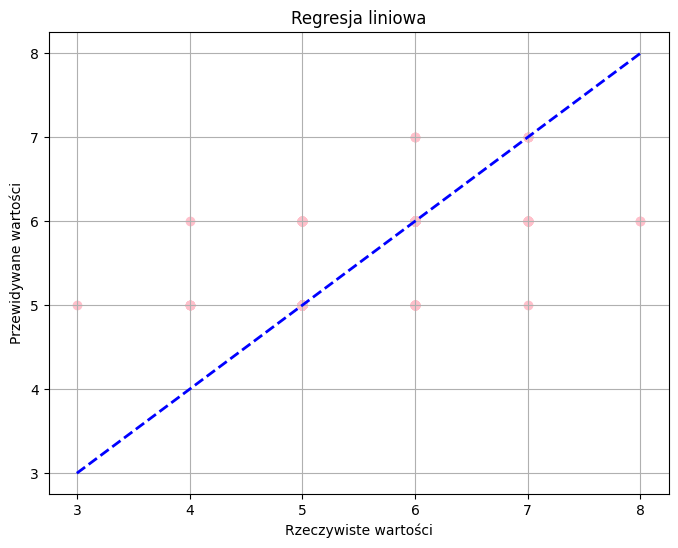

In [9]:
plt.figure(figsize=(8, 6))
plt.scatter(Y_test, y_predic, color='pink')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], color='blue', linestyle='--', linewidth=2)
plt.xlabel('Rzeczywiste wartości')
plt.ylabel('Przewidywane wartości')
plt.title('Regresja liniowa')
plt.grid(True)
plt.show()

In [10]:
y_true = Y_test
print ("regresja liniowa sredni błąd bezwględny;",  mean_absolute_error(y_true,y_predic))


regresja liniowa sredni błąd bezwględny; 0.4119718309859155


In [11]:
y_true = Y_test
print("regresja liniowa mediana róznic miedzy wartosciami prognozowanymi a rzeczywistymi",median_absolute_error(y_true,y_predic))

regresja liniowa mediana róznic miedzy wartosciami prognozowanymi a rzeczywistymi 0.0


In [12]:
y_true = Y_test
print("regresja liniowa r2", r2_score(y_true,y_predic))

regresja liniowa r2 0.259688013136289


dopasowanie wynosi tylko około 26%

#**Cross Validation regresja liniowa**


In [14]:
rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=45)
lin = LinearRegression()
cv_scores_lin = cross_val_score(lin, X_df , Y_df, cv=rkf, scoring='neg_mean_absolute_error')
print(cv_scores_lin)

[-0.46154364 -0.46584571 -0.45736567 -0.50611715 -0.48566526 -0.4690183
 -0.45141001 -0.49319685 -0.48742705 -0.46489989 -0.43932374 -0.48883731
 -0.50123565 -0.45380612 -0.49334833]


#**Huber Regressor**

In [15]:
huber = HuberRegressor().fit(X_train,Y_train)
huber.score(X_train,Y_train)
huber.coef_
huber.intercept_
y_predic_huber = np.round(huber.predict(X_test))
print (y_predic_huber)

[5. 5. 6. 6. 6. 6. 7. 6. 6. 6. 5. 6. 6. 6. 6. 5. 5. 6. 5. 6. 5. 6. 5. 6.
 6. 6. 5. 6. 6. 6. 6. 6. 5. 5. 5. 5. 6. 5. 6. 6. 5. 5. 5. 5. 5. 5. 6. 5.
 6. 5. 5. 7. 5. 6. 5. 6. 5. 5. 6. 5. 5. 6. 6. 6. 6. 6. 6. 5. 6. 6. 6. 6.
 5. 5. 5. 6. 5. 5. 6. 5. 5. 5. 5. 5. 6. 6. 5. 6. 6. 6. 5. 5. 6. 6. 5. 6.
 5. 6. 6. 6. 7. 6. 6. 6. 5. 6. 5. 5. 5. 6. 5. 5. 5. 6. 5. 5. 5. 6. 5. 5.
 5. 6. 5. 6. 5. 6. 5. 6. 5. 5. 6. 6. 6. 6. 6. 6. 6. 6. 6. 5. 6. 6. 5. 6.
 6. 7. 5. 6. 6. 5. 5. 5. 6. 7. 6. 6. 6. 5. 6. 6. 6. 5. 6. 5. 5. 5. 6. 6.
 6. 6. 5. 6. 5. 6. 5. 5. 5. 6. 6. 7. 6. 5. 6. 7. 5. 5. 6. 6. 6. 6. 6. 5.
 6. 5. 6. 6. 5. 5. 6. 6. 5. 5. 7. 6. 6. 5. 5. 6. 5. 6. 6. 5. 5. 6. 5. 5.
 5. 6. 6. 6. 5. 5. 6. 5. 5. 5. 7. 6. 7. 7. 5. 6. 5. 5. 6. 5. 6. 6. 6. 6.
 6. 6. 5. 5. 5. 6. 5. 6. 5. 6. 6. 6. 6. 6. 7. 6. 6. 5. 6. 6. 6. 6. 7. 5.
 5. 6. 5. 5. 6. 6. 6. 5. 5. 5. 6. 5. 7. 5. 5. 5. 5. 6. 5. 5.]


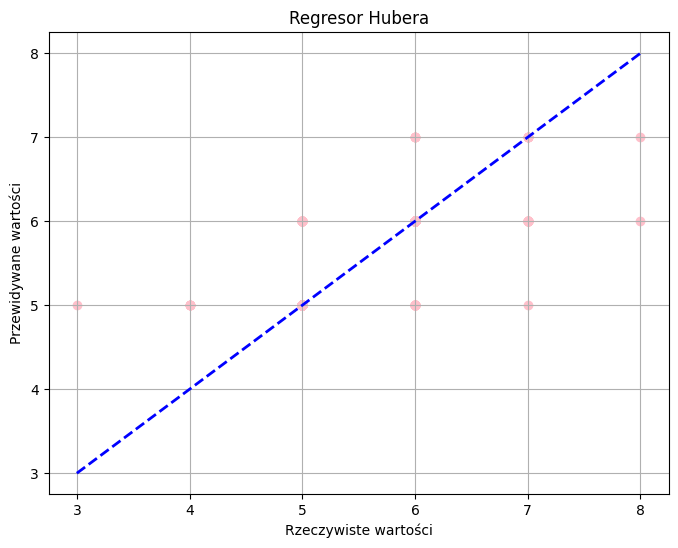

In [16]:
plt.figure(figsize=(8, 6))
plt.scatter(Y_test, y_predic_huber, color='pink')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], color='blue', linestyle='--', linewidth=2)
plt.xlabel('Rzeczywiste wartości')
plt.ylabel('Przewidywane wartości')
plt.title('Regresor Hubera')
plt.grid(True)
plt.show()

In [17]:
print("regresja Hubera",mean_absolute_error(y_true,y_predic_huber))

regresja Hubera 0.40492957746478875


In [18]:
print("regresja Hubera",median_absolute_error(y_true,y_predic_huber))

regresja Hubera 0.0


In [19]:
print("regresja Hubera r2",r2_score(y_true,y_predic_huber))

regresja Hubera r2 0.29466338259441704


dopasowanie wynosi około 29% czyli więcej niż regresja liniowa

#**Cross Validation Huber Regressor**

In [21]:
rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=45)
hub = HuberRegressor()
cv_scores_hub = cross_val_score(hub, X_df , Y_df, cv=rkf, scoring='neg_mean_absolute_error')
print(cv_scores_lin)

[-0.46154364 -0.46584571 -0.45736567 -0.50611715 -0.48566526 -0.4690183
 -0.45141001 -0.49319685 -0.48742705 -0.46489989 -0.43932374 -0.48883731
 -0.50123565 -0.45380612 -0.49334833]


#**Regresja wielomianowa 2 i 3 stopnia**

#2 stopień

In [22]:

model = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('linear', LinearRegression())
])

model.fit(X_train, Y_train)
y_predic_poly2 = np.round(model.predict(X_test))
print(y_predic_poly2)


[5. 5. 5. 6. 6. 6. 7. 6. 6. 6. 5. 7. 5. 5. 5. 5. 5. 6. 5. 6. 5. 6. 5. 6.
 6. 5. 6. 6. 6. 6. 6. 7. 6. 5. 5. 5. 5. 5. 6. 6. 5. 5. 5. 5. 5. 5. 6. 5.
 6. 5. 5. 7. 5. 6. 5. 5. 5. 5. 6. 5. 5. 7. 6. 7. 6. 6. 6. 5. 5. 6. 5. 6.
 5. 5. 5. 6. 5. 5. 6. 5. 5. 5. 5. 5. 6. 5. 5. 6. 6. 6. 5. 4. 5. 6. 5. 6.
 5. 6. 6. 6. 7. 6. 6. 6. 5. 5. 5. 5. 5. 6. 5. 5. 5. 6. 5. 5. 5. 6. 5. 5.
 5. 6. 5. 6. 5. 6. 5. 6. 5. 5. 6. 6. 6. 5. 6. 6. 6. 6. 6. 5. 6. 6. 5. 6.
 7. 7. 5. 6. 5. 5. 5. 5. 6. 7. 6. 6. 6. 5. 6. 6. 6. 5. 6. 5. 5. 6. 6. 6.
 6. 6. 5. 6. 5. 6. 5. 5. 5. 6. 6. 7. 6. 5. 6. 7. 5. 5. 6. 6. 5. 5. 6. 5.
 6. 5. 6. 6. 5. 5. 6. 6. 5. 5. 7. 6. 6. 5. 5. 5. 5. 5. 6. 5. 5. 6. 5. 5.
 5. 6. 6. 6. 5. 5. 6. 5. 5. 5. 7. 6. 7. 7. 5. 5. 5. 5. 6. 5. 7. 6. 6. 6.
 6. 6. 5. 5. 5. 5. 5. 6. 5. 6. 6. 6. 6. 6. 7. 6. 7. 5. 6. 6. 6. 6. 7. 5.
 5. 6. 5. 5. 5. 6. 6. 6. 5. 5. 6. 5. 7. 5. 6. 6. 6. 6. 5. 5.]


In [23]:

print("regresja wielomianowa 2 stopnia r2: ", model.score(X_test, Y_test))

regresja wielomianowa 2 stopnia r2:  0.35846110417687904


 dopasowanie wynosi tylko około 36% czyli więcej niz liniowa i Hubera

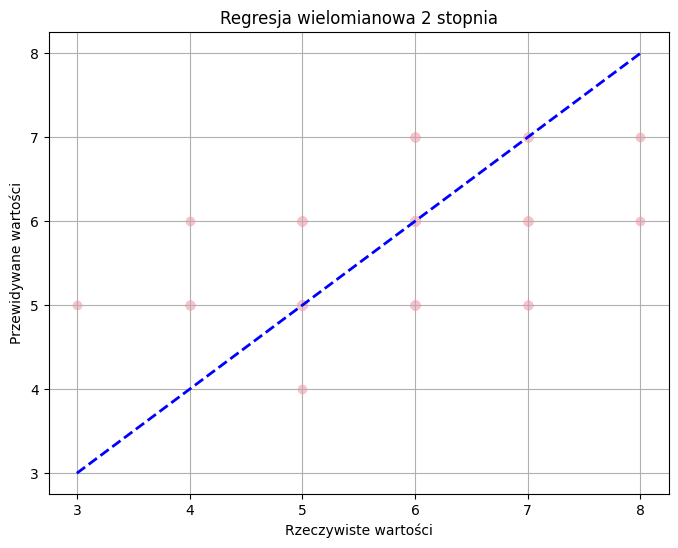

In [24]:
plt.figure(figsize=(8, 6))
plt.scatter(Y_test, y_predic_poly2, color='pink')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], color='blue', linestyle='--', linewidth=2)
plt.xlabel('Rzeczywiste wartości')
plt.ylabel('Przewidywane wartości')
plt.title('Regresja wielomianowa 2 stopnia')
plt.grid(True)
plt.show()

#**Cross validation wielomianowa 2 stopnia**


In [26]:
rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
lin = LinearRegression()
xpol2 = PolynomialFeatures(2)
X2 = xpol2.fit_transform(X_df)
cv_scores_poly2 = cross_val_score(lin, X2, Y_df, cv=rkf,scoring='neg_mean_absolute_error')
print(cv_scores_poly2)

[-0.43258811 -0.49191929 -0.45300609 -0.49978879 -0.50168609 -0.45303468
 -0.51580676 -0.49736947 -0.43998101 -0.47608461 -0.45698115 -0.46289947
 -0.48036979 -0.51892219 -0.48620798]


# 3 stopień

In [28]:
model3 = Pipeline([
    ('poly', PolynomialFeatures(degree=3)),
    ('linear', LinearRegression())
])

model3.fit(X_train, Y_train)
y_predic_poly3 = np.round(model3.predict(X_test))
print(y_predic_poly3)

[5. 4. 5. 6. 5. 6. 7. 6. 6. 5. 5. 7. 5. 6. 5. 4. 5. 6. 5. 6. 5. 5. 7. 5.
 6. 5. 5. 6. 6. 6. 5. 6. 5. 5. 5. 5. 6. 5. 7. 6. 6. 5. 6. 6. 4. 6. 6. 6.
 6. 6. 5. 7. 6. 6. 5. 5. 5. 5. 6. 6. 5. 7. 6. 7. 6. 6. 6. 5. 4. 6. 6. 6.
 5. 5. 6. 6. 5. 5. 7. 5. 5. 5. 5. 6. 5. 5. 6. 6. 6. 6. 5. 5. 5. 7. 6. 6.
 5. 6. 6. 6. 6. 6. 6. 6. 5. 5. 6. 5. 5. 5. 6. 7. 5. 6. 5. 5. 6. 6. 5. 5.
 5. 6. 5. 6. 6. 5. 5. 7. 5. 5. 6. 6. 6. 5. 6. 6. 7. 6. 6. 5. 6. 6. 6. 5.
 6. 5. 5. 6. 5. 5. 5. 6. 5. 7. 6. 5. 6. 5. 4. 5. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 7. 5. 6. 5. 6. 5. 5. 5. 6. 6. 7. 5. 6. 5. 6. 5. 6. 5. 6. 5. 5. 6. 5.
 6. 5. 5. 6. 5. 5. 6. 6. 5. 5. 9. 5. 6. 5. 5. 5. 6. 5. 6. 5. 5. 6. 5. 6.
 5. 6. 6. 6. 4. 5. 5. 5. 5. 5. 7. 6. 6. 7. 5. 5. 5. 5. 6. 5. 7. 6. 6. 6.
 6. 6. 6. 5. 5. 5. 6. 6. 5. 6. 4. 6. 6. 6. 7. 6. 6. 5. 6. 6. 6. 6. 6. 5.
 6. 6. 5. 6. 6. 5. 6. 6. 6. 5. 6. 5. 7. 5. 6. 6. 5. 6. 6. 5.]


In [29]:
print("regresja wielomianowa 3 stopnia r2: ", model3.score(X_test, Y_test))

regresja wielomianowa 3 stopnia r2:  0.09394065957737918


Dzięki r2 mozemy zobaczyć iż regresja wielomianowa 3 stopnia jest najgorszym wyborem z przedstawionych gdyż dopasowanie wynosi tylko 09%

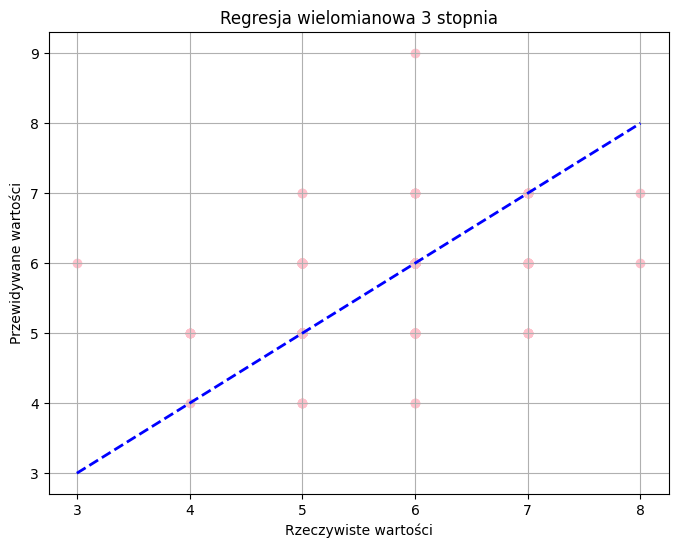

In [30]:
plt.figure(figsize=(8, 6))
plt.scatter(Y_test, y_predic_poly3, color='pink')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], color='blue', linestyle='--', linewidth=2)
plt.xlabel('Rzeczywiste wartości')
plt.ylabel('Przewidywane wartości')
plt.title('Regresja wielomianowa 3 stopnia')
plt.grid(True)
plt.show()

#**Cross Validation wielomianowa 3 stopnia**

In [31]:
rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
lin = LinearRegression()
xpol3 = PolynomialFeatures(3)
X3 = xpol3.fit_transform(X_df)
cv_scores_poly3 = cross_val_score(lin, X3, Y_df, cv=rkf,scoring='neg_mean_absolute_error')
print(cv_scores_poly3)

[-0.5364566  -0.52907812 -0.554277   -0.53629986 -0.5482538  -0.50638805
 -0.58737182 -0.53823763 -0.49480672 -0.50118672 -0.46798315 -0.51548363
 -0.48449953 -0.56387454 -0.55093456]


#**Cross Validation KNN**

In [32]:
knn_cv = KNeighborsRegressor(n_neighbors=3)
cv_scores_knn = cross_val_score(knn_cv, X_df, Y_df, cv=rkf,scoring='neg_mean_absolute_error')
print(cv_scores_knn)

[-0.47723935 -0.49339207 -0.47136564 -0.45374449 -0.46255507 -0.43906021
 -0.50220264 -0.48311307 -0.4287812  -0.48604993 -0.43759178 -0.48898678
 -0.48751836 -0.49926579 -0.47723935]


In [33]:
# sklearn.metrics.get_scorer_names()

#**Box plot porówniania cross validation wszystkich modeli**

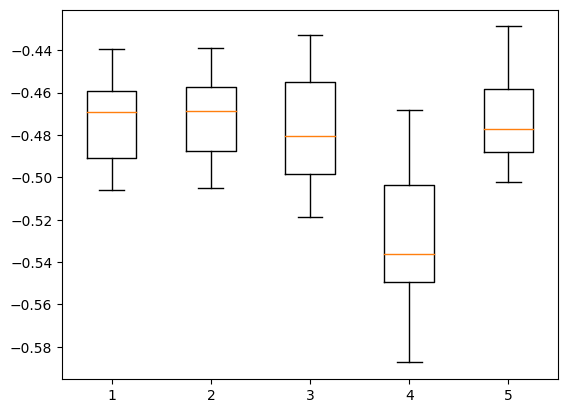

In [34]:
plt.boxplot([cv_scores_lin,cv_scores_hub, cv_scores_poly2, cv_scores_poly3, cv_scores_knn])
plt.show()